In [1]:
from Go2Py.robot.interface import GO2Real

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from Go2Py.robot.model import Go2Model

In [3]:
model = Go2Model()

In [4]:
robot=GO2Real()

In [6]:
state = robot.getJointStates()
state

{'q': [0.3250521421432495,
  0.40270543098449707,
  -1.4649406671524048,
  -0.44037926197052,
  0.35583579540252686,
  -1.469537615776062,
  0.41242796182632446,
  0.29579007625579834,
  -1.4764724969863892,
  -0.38193845748901367,
  0.25427955389022827,
  -1.4649723768234253],
 'dq': [0.007751047611236572,
  0.01937761902809143,
  -0.014154086820781231,
  0.034879714250564575,
  0.04263076186180115,
  0.008088049478828907,
  -0.034879714250564575,
  -0.06200838088989258,
  0.024264149367809296,
  0.034879714250564575,
  -0.003875523805618286,
  -0.03033018670976162],
 'tau_est': [-0.14842969179153442,
  0.12369140982627869,
  -0.1422451138496399,
  -0.22264453768730164,
  -0.12369140982627869,
  0.3319052755832672,
  0.049476563930511475,
  0.0,
  -0.09483008086681366,
  0.049476563930511475,
  -0.024738281965255737,
  0.0],
 'temperature': [27.0,
  24.0,
  26.0,
  26.0,
  25.0,
  26.0,
  27.0,
  25.0,
  26.0,
  27.0,
  24.0,
  25.0]}

In [7]:
from scipy.spatial.transform import Rotation as R
import numpy as np
imu = robot.getIMU()
guat = imu['quat']
Rot_mat = R.from_quat(guat).as_matrix()
T = np.eye(4)
T[:3,:3]=Rot_mat

q = np.array(state['q'])
dq = np.array(state['dq'])

In [8]:
state.keys()

dict_keys(['q', 'dq', 'tau_est', 'temperature'])

In [9]:
model.updateAllPose(q, dq, T, np.zeros(6))

In [10]:
model.getInfo()['g'][6:]

array([-0.68048197,  0.24158602, -0.19297757,  0.58341235,  0.2037472 ,
       -0.19295897, -0.58055523,  0.15918967, -0.20132737,  0.64800928,
        0.12985214, -0.21048951])

In [11]:
def getGravComp(model, state, imu):
    imu = robot.getIMU()
    guat = imu['quat']
    Rot_mat = R.from_quat(guat).as_matrix()
    T = np.eye(4)
    T[:3,:3]=Rot_mat

    q = np.array(state['q'])
    dq = np.array(state['dq'])
    model.updateAllPose(q, dq, T, np.zeros(6))
    return model.getInfo()['g'][6:]

In [46]:
import numpy as np
import time
start_time = time.time()
freq = 3
omega = np.pi*2*freq
A = 1.5
while time.time()-start_time < 30:
    state = robot.getJointStates()
    imu = robot.getIMU()
    grav = getGravComp(model, state, imu)
    q = np.zeros(12) 
    dq = np.zeros(12)
    kp = np.ones(12)*0.0
    kd = np.ones(12)*0.0
    tau = np.zeros(12)
    # tau[2] = A*np.sin(omega*(time.time()-start_time))
    tau = grav

    robot.setCommands(q, dq, kp, kd, tau)
    time.sleep(0.001)

KeyboardInterrupt: 

In [12]:
import numpy as np
import time
start_time = time.time()
freq = 2.
omega = np.pi*2*freq
q_nominal = robot.standing_q
As = [0.5, 1., 1.5, 2, 2.5]
freqs = [1.5, 2., 2.5, 3., 3.5]
A = 0 

# Go home before anything
while time.time()-start_time < 3:
    state = robot.getJointStates()
    imu = robot.getIMU()
    grav = getGravComp(model, state, imu)
    q = q_nominal 
    dq = np.zeros(12)
    kp = np.ones(12)*3.0
    kd = np.ones(12)*0.1
    tau = np.zeros(12)
    robot.setCommands(q, dq, kp, kd, tau)
# Start recording a dataset for the knee joints
dataset = []
for freq in freqs:
    omega = np.pi*2*freq
    for A in As:
        start_time=time.time()
        while time.time()-start_time < 5:
            state = robot.getJointStates()
            imu = robot.getIMU()
            grav = getGravComp(model, state, imu)
            q = q_nominal 
            dq = np.zeros(12)
            kp = np.ones(12)*3.0
            kd = np.ones(12)*0.1
            tau = np.zeros(12)
            tau = grav
            # The internal controller of the knee joints should not be active 
            kp[2]=kp[5]=kp[8]=kp[11]=0.
            kd[2]=kd[5]=kd[8]=kd[11]=0.
            pd_law = 6.3*(q_nominal-state['q']) + 0.5*(np.array([0])-state['dq'])
            tau[2] = A*np.sin(omega*(time.time()-start_time)) + grav[2] + pd_law[2]
            tau[5] = A*np.sin(omega*(time.time()-start_time)) + grav[5] + pd_law[5]
            tau[8] = A*np.sin(omega*(time.time()-start_time)) + grav[8] + pd_law[8]
            tau[11] = A*np.sin(omega*(time.time()-start_time)) + grav[11] + pd_law[11]
            robot.setCommands(q, dq, kp, kd, tau)
            q = np.array(state['q'])
            dq = np.array(state['dq'])
            tau_recorded = np.array(state['tau_est'])
            dataset.append([tau[[2,5,8,11]], q[[2,5,8,11]], dq[[2,5,8,11]], tau_recorded[[2,5,8,11]]])
            time.sleep(0.01)

dataset = np.array(dataset)

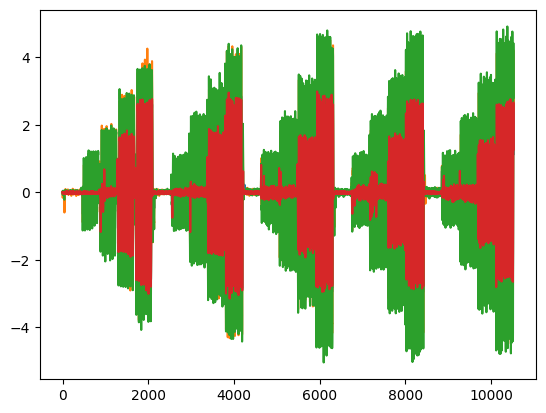

In [13]:
import matplotlib.pyplot as plt
plt.plot(dataset[:,-2])

In [14]:
import pickle
with open('knee_friction_identification_dataset.pkl', 'wb') as f:
    pickle.dump(
        {'q': dataset[:,1],
         'dq': dataset[:,2],
         'tau': dataset[:,0],
         'tau_recorded': dataset[:,-1],},
         f
    )

# Curve fitting

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import pickle
dataset = pickle.load(open('knee_friction_identification_dataset.pkl', 'rb'))

In [4]:
class FrictionSSID(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu_v = nn.Parameter(data=torch.zeros(1), requires_grad=True)
        self.Fs = nn.Parameter(data=torch.zeros(1), requires_grad=True)
        self.register_buffer("temperature", 0.1 * torch.ones(()))

    def forward(self, dq):
        tau_sticktion = self.Fs*self.softSign(dq, temperature=self.temperature)
        tau_viscose = self.mu_v*dq
        return tau_sticktion+tau_viscose

    def softSign(self, u, temperature=0.1):
        return torch.tanh(u/temperature)

In [13]:
for knee_nb in range(4):
    epoch_nb = 100
    friction_model = FrictionSSID()
    optim = torch.optim.SGD(params=friction_model.parameters(), lr=0.2)
    for e in range(epoch_nb):
        dq = torch.tensor(dataset['dq'][:, knee_nb])
        tau_applied = torch.tensor(dataset['tau'][:, knee_nb])
        tau_recorded = torch.tensor(dataset['tau_recorded'][:, knee_nb])
        loss = ((tau_applied + tau_recorded - friction_model(dq)) ** 2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        if (e) % 25 == 0:
            print(f"knee nb.: {knee_nb}, epgetJointStatesoch {e+1}/{epoch_nb}, loss: {loss.item()}")
    print(f"mu_v: {friction_model.mu_v}, Fs: {friction_model.Fs}")
    torch.save(friction_model, f"friction_model_knee_{knee_nb}")

knee nb.: 0, epgetJointStatesoch 1/100, loss: 3.2810028187543234
knee nb.: 0, epgetJointStatesoch 26/100, loss: 1.5961371864755898
knee nb.: 0, epgetJointStatesoch 51/100, loss: 1.5878992784766226
knee nb.: 0, epgetJointStatesoch 76/100, loss: 1.5875244340091612
mu_v: Parameter containing:
tensor([0.2167], requires_grad=True), Fs: Parameter containing:
tensor([1.5259], requires_grad=True)
knee nb.: 1, epgetJointStatesoch 1/100, loss: 2.5653999508271745
knee nb.: 1, epgetJointStatesoch 26/100, loss: 1.620573471383013
knee nb.: 1, epgetJointStatesoch 51/100, loss: 1.6184235904911686
knee nb.: 1, epgetJointStatesoch 76/100, loss: 1.6184084277930868
mu_v: Parameter containing:
tensor([-0.0647], requires_grad=True), Fs: Parameter containing:
tensor([1.2380], requires_grad=True)
knee nb.: 2, epgetJointStatesoch 1/100, loss: 2.281400742101678
knee nb.: 2, epgetJointStatesoch 26/100, loss: 1.7584790933593724
knee nb.: 2, epgetJointStatesoch 51/100, loss: 1.7573205771828757
knee nb.: 2, epgetJo

Text(0, 0.5, 'friction')

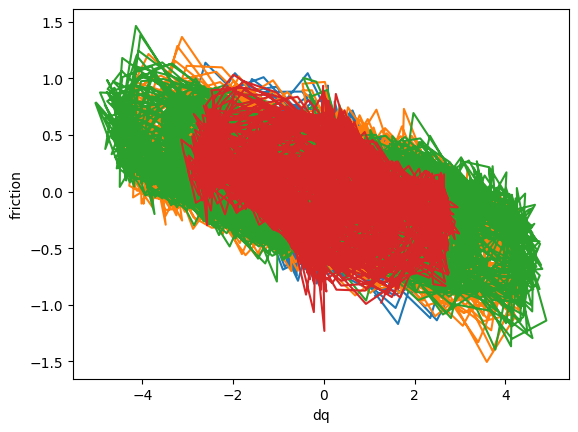

In [16]:
import matplotlib.pyplot as plt
plt.plot(dataset['dq'], dataset['tau']-dataset['tau_recorded'])
plt.xlabel("dq")
plt.ylabel("friction")